In [2]:
import numpy as np
import pandas as pd
import os
import json
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import random
import cv2
from pycocotools.coco import COCO
import time

import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from sklearn import metrics

import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torchvision.models import mobilenet_v3_large
import torch.nn as nn
from torch.nn import functional as F

In [3]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d watchman/rtsd-dataset
# !unzip rtsd-dataset.zip
# !rm rtsd-dataset.zip
# !cp -r rtsd-frames/rtsd-frames/ .
# !rm -r rtsd-frames/rtsd-frames/

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# !cp chkpt_model1_d_1.pth /content/drive/MyDrive

In [6]:
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'

n_epochs = 15
batch_size = 10
classes = 2
classes1 = 157
device

'cpu'

In [24]:
# функция загрузки датасета в pd
def dataset(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
  
  return df

In [25]:
df_train_anno = dataset('.', 'train_anno.json')
df_val_anno = dataset('.', 'val_anno.json')
df_train_anno_reduced = dataset('.', 'train_anno_reduced.json')

In [26]:
dfa = df_train_anno.copy().reset_index()
dfa = dfa.drop(['index'],axis=1)
dfa.iloc[10:50, 4] = dfa.iloc[10:50, 4].apply(lambda x: [int(x[0]-0.5*x[2]), int(x[1]-0.5*x[3]), x[2], x[3]])
dfa.iloc[10:50, 2] = 156
dfa.iloc[10:50, 6] = '0_0'
dfa

,id,image_id,category_id,area,bbox,iscrowd,name,width,height,file_name
0,0,0,1,324,"[649, 376, 18, 18]",0,2_1,1280,720,rtsd-frames/autosave01_02_2012_09_13_33.jpg
1,1,1,1,420,"[671, 356, 20, 21]",0,2_1,1280,720,rtsd-frames/autosave01_02_2012_09_13_34.jpg
2,2,2,1,702,"[711, 332, 27, 26]",0,2_1,1280,720,rtsd-frames/autosave01_02_2012_09_13_35.jpg
3,3,3,1,1332,"[764, 290, 37, 36]",0,2_1,1280,720,rtsd-frames/autosave01_02_2012_09_13_36.jpg
4,4,3,2,289,"[684, 384, 17, 17]",0,1_23,1280,720,rtsd-frames/autosave01_02_2012_09_13_36.jpg
...,...,...,...,...,...,...,...,...,...,...
95487,70506,38149,149,2100,"[1007, 307, 35, 60]",0,6_8_1,1280,720,rtsd-frames/autosave16_10_2012_08_36_42_2.jpg
95488,70507,38150,149,3150,"[1088, 296, 45, 70]",0,6_8_1,1280,720,rtsd-frames/autosave16_10_2012_08_36_43_0.jpg
95489,102242,57700,154,1519,"[712, 329, 31, 49]",0,7_14,1280,720,rtsd-frames/autosave24_10_2013_11_23_19_1.jpg
95490,102243,57701,154,2340,"[767, 306, 39, 60]",0,7_14,1280,720,rtsd-frames/autosave24_10_2013_11_23_19_2.jpg


In [27]:
class RTSD_dataset_clf_my(Dataset):
    def __init__(self, path_img, df, transforms=None):
        super().__init__()
        self.path_img = path_img
        self.transforms = transforms
        self.df = df
        
    def __getitem__(self, index):
        name_img = self.df.loc[index,'file_name']
        boxes = self.df.loc[index,'bbox']
        bb = [boxes[0], boxes[1], boxes[0] + boxes[2], boxes[1] + boxes[3]]
        imgs = Image.open(os.path.join(self.path_img, name_img))
        imgs = imgs.crop(bb)

        if self.transforms is not None:
            imgs = self.transforms(imgs)

        imgs = imgs / 255

        targets = torch.tensor(self.df.loc[index, 'category_id'])


#         return imgs, targets
        return {
                'images': imgs,
                'targets': targets}
    
    def __len__(self):
        
        return self.df.shape[0]

In [28]:
def get_transform1():
#     custom_transforms = []
#     custom_transforms.append(transforms.ToTensor())
    return transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])

In [29]:
def get_transform_a1():
             return transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomChoice([transforms.Compose([transforms.RandomPerspective(distortion_scale=0.4,p=0.9),
                                                                                    transforms.ToTensor()
                                                                                    ]),
                                                                transforms.Compose([transforms.ColorJitter(brightness=(0.4), contrast=(0.3), saturation=(0.3)),
                                                                                    transforms.ToTensor()
                                                                                    ]),
                                                                transforms.Compose([transforms.RandomResizedCrop((224,224), scale=(0.85, 1)), # Случайная обрезка изображения в диапахоне 85 - 100% и resize в исходный размер
                                                                                    transforms.ToTensor()
                                                                                    ])        
                                                                ])
                                       ])


In [30]:
df12 = RTSD_dataset_clf_my('./', dfa, transforms=get_transform1())
df112 = RTSD_dataset_clf_my('./', df_val_anno, transforms=get_transform1())
df222 = RTSD_dataset_clf_my('./', dfa, transforms=get_transform_a1())
df122 = RTSD_dataset_clf_my('./', df_val_anno, transforms=get_transform1())

In [31]:
data_loader_train12 = torch.utils.data.DataLoader(df12,
                                          batch_size=batch_size,
                                          shuffle=True, drop_last = True)

data_loader_val12 = torch.utils.data.DataLoader(df112,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last = True)
data_loader_train22 = torch.utils.data.DataLoader(df222,
                                          batch_size=batch_size,
                                          shuffle=True, drop_last = True)

data_loader_val22 = torch.utils.data.DataLoader(df122,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last = True)

In [32]:
def show_tranformed_image2(train_loader):
    if len(train_loader) > 0:
        for i in range(1):
            data = next(iter(train_loader))
            images, targets = data['images'], data['targets']
#             images, targets = next(iter(train_loader))
            images = list(image.to(device) for image in images)
            sample = images[i].permute(1, 2, 0).detach().cpu().numpy()
            sample = sample * 255
            targets = [t.to(device) for t in targets]
            targets = targets[i].item()
            
            plt.imshow(sample)
            plt.title(targets)
            plt.axis('off')
            plt.show()

In [33]:
show_tranformed_image2(data_loader_train22)

In [34]:
def show_tranformed_image12(train_loader):
            figure = plt.figure(figsize=(10, 8))
            cols, rows = 3, 3
            if len(train_loader) > 0:
                  for i in range(1, cols * rows + 1):
                              for j in range(1):
                                  data = next(iter(train_loader))
                                  images, targets = data['images'], data['targets']
                                    
#                                   images, targets = next(iter(train_loader))
#                                   images = list(image.to(device) for image in images)
#                                   targets = [t.to(device) for t in targets]
                                  targets = targets[j].item()
                                  sample = images[j].permute(1, 2, 0).detach().cpu().numpy()
                                  sample = sample * 255
                                  figure.add_subplot(rows, cols, i)
                                                    
                                  plt.imshow(sample)
                                  
                                  plt.title(targets)
                                  plt.axis("off")
            plt.show()

In [35]:
show_tranformed_image12(data_loader_train22)

In [12]:
class ResidualBlock(nn.Module):
    """
    Creates the Residual block of ResNet.
    """
    def __init__(
        self, in_channels, out_channels, use_1x1conv=True, strides=1
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        inputs = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        if self.conv3:
            inputs = self.conv3(inputs)
        x += inputs
        return F.relu(x)

In [13]:
def create_resnet_block(
    input_channels,
    output_channels, 
    num_residuals,
):
        resnet_block = []
        for i in range(num_residuals):
            if i == 0:
                resnet_block.append(ResidualBlock(input_channels, output_channels,
                                    use_1x1conv=True, strides=2))
            else:
                resnet_block.append(ResidualBlock(output_channels, output_channels))
        return resnet_block 

In [14]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=157):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(16), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.block2 = nn.Sequential(*create_resnet_block(16, 32, 2))
        self.block3 = nn.Sequential(*create_resnet_block(32, 64, 2))
        self.block4 = nn.Sequential(*create_resnet_block(64, 128, 2))
        self.block5 = nn.Sequential(*create_resnet_block(128, 256, 2))
        self.linear = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.linear(x)
        return x 

In [25]:
model = CustomResNet().to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [40]:
def load_ckp1(checkpoint_fpath, model):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath, map_location=device)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint)
    
    return model


In [41]:
model_conv1 = CustomResNet().to(device)

model = load_ckp1('./chkpt_m1c_clf_8.pth', model_conv1)
optimizer = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [1]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []   

y_true_t, y_true_v = [], []
y_pred_t, y_pred_v = [], []

for epoch in range(9, n_epochs):
    start = time.time()
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    train_class_correct = list(0. for i in range(classes1))
    train_class_total = list(0. for i in range(classes1))
    for i, batch in enumerate(data_loader_train12):
        optimizer.zero_grad()
        image, targets = batch['images'].to(device), batch['targets'].to(device)
#         image = list(img.to(device) for img in image)
#         targets = [t.to(device) for t in targets]
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = loss_func(outputs, targets)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs, 1)
        train_running_correct += (preds == targets).sum().item()
        correct  = (preds == targets).squeeze()
        for a in range(len(preds)):
                label = targets[a]
                # print(label)
                train_class_correct[label] += correct[a].item()
                train_class_total[label] += 1
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()     
        
        y_true_t.extend([int(item) for item in targets])
        y_pred_t.extend([int(item) for item in preds])
        
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    
    # Loss and accuracy for the complete epoch.
    train_epoch_loss = train_running_loss / i
    train_epoch_acc = 100. * (train_running_correct / len(df12))
    
    
    
    train_epoch_accuracy = metrics.accuracy_score(y_true_t, y_pred_t)
    train_epoch_f1_micro = metrics.f1_score(y_true_t, y_pred_t, average="micro")
    train_epoch_f1_macro =  metrics.f1_score(y_true_t, y_pred_t, average="macro")
    train_epoch_f1_weighted = metrics.f1_score(y_true_t, y_pred_t, average="weighted")
    
    
    
    print('Эпоха train:', epoch,'Итераций:', i, 'train loss:', train_epoch_loss, 'train acc:', train_epoch_acc)
    
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    # We need two lists to keep track of class-wise accuracy.
    class_correct = list(0. for i in range(classes1))
    class_total = list(0. for i in range(classes1))
    with torch.no_grad():
        for i, batch in enumerate(data_loader_val12):
#             image, targets = batch
            image, targets = batch['images'].to(device), batch['targets'].to(device)
#             image = list(img.to(device) for img in image)
#             targets = [t.to(device) for t in targets]
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = loss_func(outputs, targets)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs, 1)
            valid_running_correct += (preds == targets).sum().item()
            # Calculate the accuracy for each class.
            correct  = (preds == targets).squeeze()
            for j in range(len(preds)):
                label = targets[j]
                # print(label)
                class_correct[label] += correct[j].item()
                class_total[label] += 1
        
            if i % 200 == 0:
                 print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
                    
            y_true_v.extend([int(item) for item in targets])
            y_pred_v.extend([int(item) for item in preds])
        
    # Loss and accuracy for the complete epoch.
    valid_epoch_loss = valid_running_loss / i
    valid_epoch_acc = 100. * (valid_running_correct / len(df112))
    
    valid_epoch_accuracy = metrics.accuracy_score(y_true_v, y_pred_v)
    valid_epoch_f1_micro = metrics.f1_score(y_true_v, y_pred_v, average="micro")
    valid_epoch_f1_macro =  metrics.f1_score(y_true_v, y_pred_v, average="macro")
    valid_epoch_f1_weighted = metrics.f1_score(y_true_v, y_pred_v, average="weighted")
    
    end = time.time()
    print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
    print('Эпоха val:', epoch, 'Итераций:', i, 'val loss:', valid_epoch_loss, 'val acc:', valid_epoch_acc)
    
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    
    torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'accuracy_train': train_epoch_accuracy,
                    'f1_micro_trainl': train_epoch_f1_micro,
                    'f1_macro_train': train_epoch_f1_macro,
                    'f1_weighted_train': train_epoch_f1_weighted,
                    'loss_train': train_loss,
                    'acc_train': train_acc,
                    'accuracy_val': valid_epoch_accuracy,
                    'f1_micro_val': valid_epoch_f1_micro,
                    'f1_macro_val': valid_epoch_f1_macro,
                    'f1_weighted_val': valid_epoch_f1_weighted,
                    'loss_val': valid_loss,
                    'acc_val': valid_acc
                    }, f'./chkpt_model1c_clf_{epoch}.pth')
    
    torch.save(model.state_dict(), f'./chkpt_m1c_clf_{epoch}.pth')

In [ ]:
#  torch.save({'epoch': epoch,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'accuracy_train': train_epoch_accuracy,
#                     'f1_micro_trainl': train_epoch_f1_micro,
#                     'f1_macro_train': train_epoch_f1_macro,
#                     'f1_weighted_train': train_epoch_f1_weighted,
#                     'loss_train': train_loss,
#                     'acc_train': train_acc,
#                     'accuracy_val': valid_epoch_accuracy,
#                     'f1_micro_val': valid_epoch_f1_micro,
#                     'f1_macro_val': valid_epoch_f1_macro,
#                     'f1_weighted_val': valid_epoch_f1_weighted,
#                     'loss_val': valid_loss,
#                     'acc_val': valid_acc
#                     }, f'./chkpt_model1c_clf_{epoch}.pth')

In [7]:
checkpoint2 = torch.load('./chkpt_model1c_clf_8.pth', map_location=device)

In [8]:
t = 'CustomResNet'

Text(0.5, 1.0, 'CustomResNet')

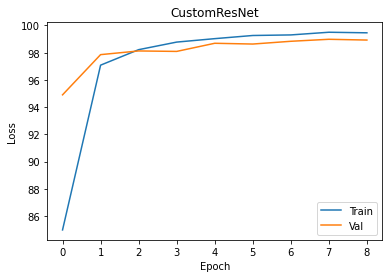

In [18]:
%matplotlib inline
# тренировка на большом датасете
fig, ax  = plt.subplots()
ax.plot(checkpoint2['acc_train'], label='Train')
ax.plot(checkpoint2['acc_val'], label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.title('{}'.format(t))

Text(0.5, 1.0, 'CustomResNet')

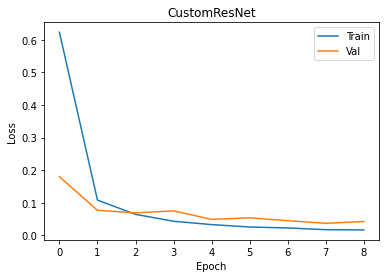

In [19]:
%matplotlib inline
# тренировка на большом датасете
fig, ax  = plt.subplots()
ax.plot(checkpoint2['loss_train'], label='Train')
ax.plot(checkpoint2['loss_val'], label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.title('{}'.format(t))

In [20]:
transform = transforms.Compose([transforms.ToTensor(),])

In [21]:
model_c = CustomResNet()
checkpoint = torch.load('./chkpt_m1c_clf_8.pth', map_location=device)
model_c.load_state_dict(checkpoint)#['model_state_dict'])

<All keys matched successfully>

In [22]:
# функция загрузки датасета в pd
def dataset(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
  
  return df

In [23]:
df_val = dataset('.', 'val_anno.json')

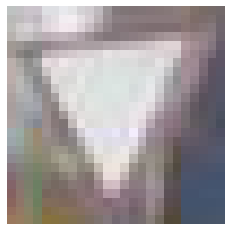

predict: 1
true:    13


In [25]:
model_c.eval()
y = np.random.choice(df_val.file_name)
im_labels = df_val[df_val.file_name == y].iloc[0]
label = df_val[df_val.file_name == y].iloc[0]['category_id']

im = Image.open('./' + y)
coordinates = [im_labels.bbox[0], im_labels.bbox[1], im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]]
cropped = im.crop(coordinates)

plt.imshow(cropped)
plt.axis('off')
plt.show()

image = transform(cropped).to(device)
image = image.unsqueeze(0)
predict = torch.argmax(model_c(image)).detach().cpu().numpy()

print(f"predict: {predict}")
print(f"true:    {label}")

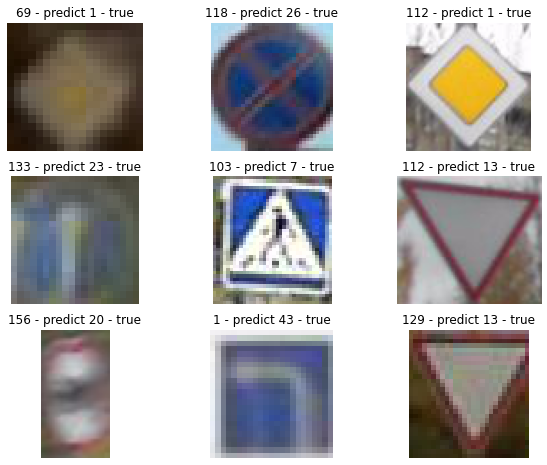

In [27]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    r = np.random.choice(df_val.file_name)
    im_labels = df_val[df_val.file_name == r].iloc[0]
    label = df_val[df_val.file_name == r].iloc[0]['category_id']
    im = Image.open('./' + r)
    figure.add_subplot(rows, cols, i)
    coordinates = ((im_labels.bbox[0], im_labels.bbox[1], im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]))
    cropped = im.crop(coordinates)
    image = transform(cropped).to(device)
    image = image.unsqueeze(0)
    predict = torch.argmax(model_c(image)).detach().cpu().numpy()
    plt.imshow(cropped)
    plt.title('{} - predict {} - true'.format(predict, label))
    plt.axis("off")
plt.show()